In [1]:

from importlib import reload
from typing import Dict, List

import numpy as np
import numpy.typing as npt
import scipy.io as sio
import seaborn
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, losses

import spectrum_painting as sp
from spectrogram import Spectrogram, split_spectrogram
from spectrogram import create_spectrogram

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
def load_data_from_matlab(file: str) -> npt.NDArray[np.complex128]:
    """
    Load the list of complex numbers from Matlab files.
    """
    # each complex number is in its own row and so is put in
    # its own array. 'squeeze' flattens the array.
    return sio.loadmat(file)["WaveformOut"].squeeze()


data: Dict[str, npt.NDArray[np.complex128]] = {
    "z": load_data_from_matlab("data/matlab/Z_SNR30.mat"),
    "b": load_data_from_matlab("data/matlab/B_SNR30.mat"),
    "w": load_data_from_matlab("data/matlab/W_SNR30.mat"),
    "bw": load_data_from_matlab("data/matlab/BW_SNR30.mat"),
    "zb": load_data_from_matlab("data/matlab/ZB_SNR30.mat"),
    "zw": load_data_from_matlab("data/matlab/ZW_SNR30.mat"),
    "zbw": load_data_from_matlab("data/matlab/ZBW_SNR30.mat"),
}

In [4]:
def plot_spectrogram(spectrogram: Spectrogram):
    plt.pcolormesh(spectrogram.f, spectrogram.t, spectrogram.values.T, shading="nearest")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Time (s)")
    plt.title("Spectrogram")
    plt.colorbar(label="Magnitude (dB)")
    plt.show()

In [5]:
# Sampling frequency
fs = 20000000  # 20MHz

spectrograms: Dict[str, Spectrogram] = {key: create_spectrogram(frame, fs) for key, frame in data.items()}

In [6]:
reload(sp)
# middle: int = len(spectrograms["zbw"].values) // 2
# start_freq: int = middle - 40
# end_freq: int = middle + 40
# 
# demo_spectrogram = sp.take_frequencies(spectrograms["zbw"], start_freq, end_freq)
# demo_spectrogram = split_spectrogram(demo_spectrogram, 1000)[0]
# demo_spectrogram.values = demo_spectrogram.values.clip(0, 0.0000001)
# 
# plt.pcolormesh(demo_spectrogram.f, demo_spectrogram.t, demo_spectrogram.values.T, shading="nearest")
# plt.show()
# 
# demo_spectrogram = sp.downsample_spectrogram(demo_spectrogram.values, 16)
# plt.imshow(demo_spectrogram.T)
# plt.show()
# 
# augmented_demo_spectrogram = sp.augment_spectrogram(spectrogram=demo_spectrogram, k=4, l=3, d=1)
# plt.imshow(augmented_demo_spectrogram)
# plt.show()
# 
# demo_spectrogram = sp.paint_spectrogram(demo_spectrogram, augmented_demo_spectrogram)
# demo_spectrogram = sp.digitize_spectrogram(demo_spectrogram, 256)
# plt.imshow(demo_spectrogram)
# plt.show()

<module 'spectrum_painting' from '/Users/sethd/Desktop/spectrum-painting/training/spectrum_painting.py'>

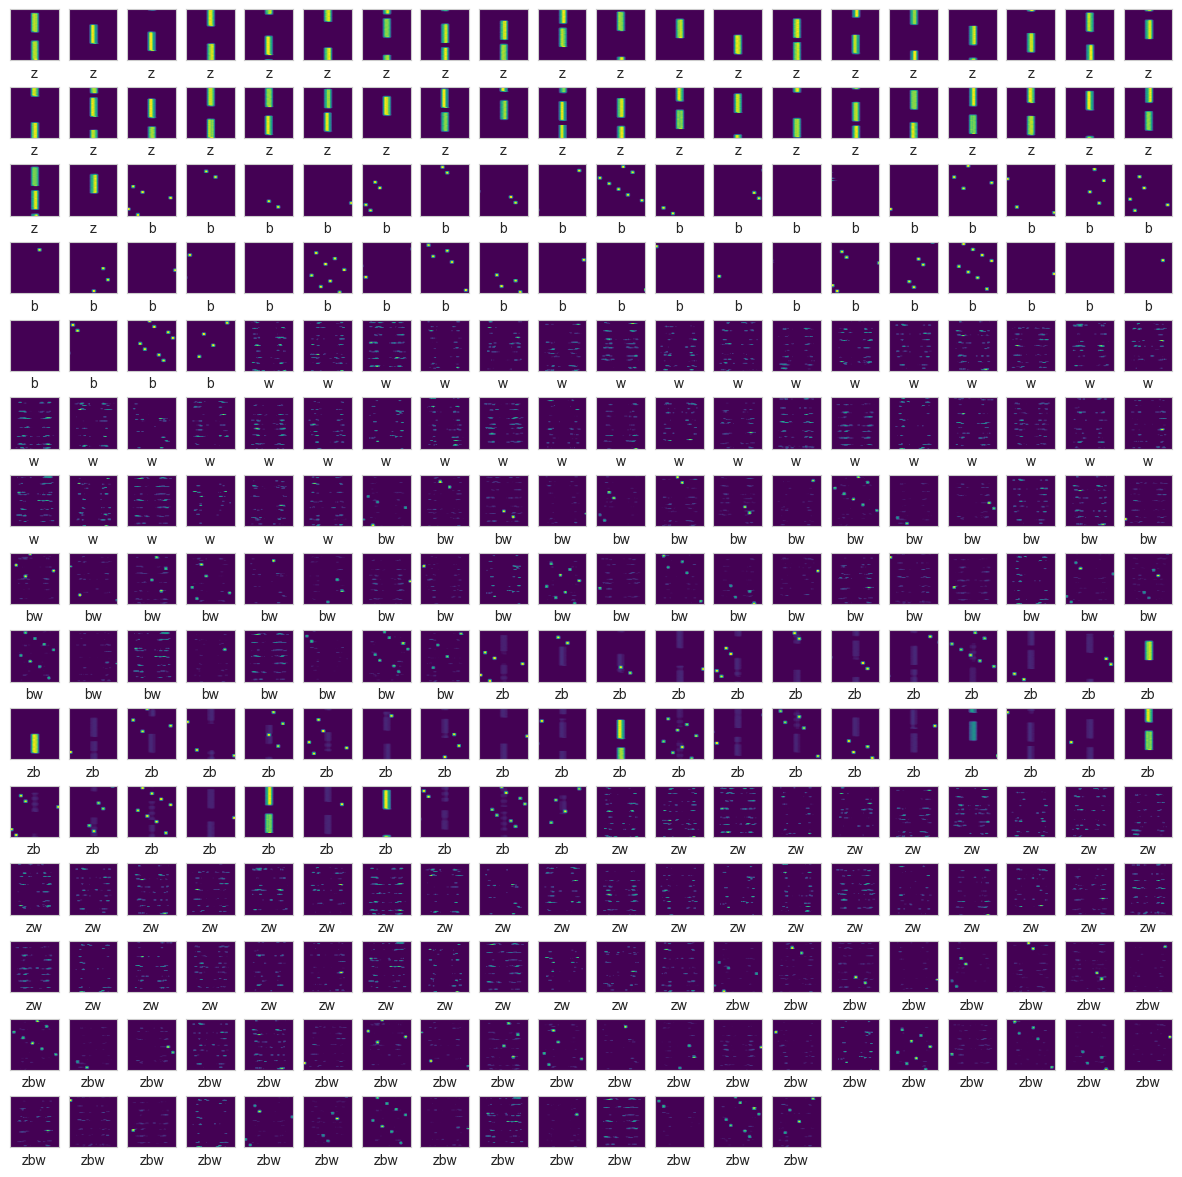

Number of training images: 205


In [7]:
# Reload spectrum painting module in case the code changed
# and you want what is executed to be what you told the computer
# to do.
reload(sp)

downsample_resolution = 64

K = 3
L = 4
D = 1

color_depth = 256

x_train_augmented: List[npt.NDArray[np.float32]] = []
x_train_painted: List[npt.NDArray[np.float32]] = []
labels: List[np.uint8] = []
label_names: List[str] = []

for (class_index, (label, spec)) in enumerate(spectrograms.items()):
    middle: int = len(spec.values) // 2
    start_freq: int = middle - 32
    end_freq: int = middle + 32

    spec = sp.take_frequencies(spec, start_freq, end_freq)

    slices = split_spectrogram(spec, duration=4000)

    downsampled_slices = [sp.downsample_spectrogram(s.values, downsample_resolution) for s in slices]
    augmented_slices = [sp.augment_spectrogram(s, K, L, D) for s in downsampled_slices]

    for s in augmented_slices:
        x_train_augmented.append(sp.digitize_spectrogram(s, color_depth))

    painted_slices = [sp.paint_spectrogram(original, augmented) for (original, augmented) in
                      list(zip(downsampled_slices, augmented_slices))]

    for s in painted_slices:
        x_train_painted.append(sp.digitize_spectrogram(s, color_depth))

    for i in range(len(slices)):
        labels.append(class_index)

    label_names.append(label)

plt.figure(figsize=(15, 20))
for i in range(len(x_train_painted)):
    image = x_train_painted[i]
    plt.subplot(20, 20, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap="viridis")
    plt.xlabel(label_names[labels[i]])
plt.show()

x_train_combined = np.stack((x_train_augmented, x_train_painted), axis=3)

x_train, x_test, y_train, y_test = train_test_split(x_train_combined, labels, test_size=0.3, random_state=42)

# for tensorflow it must be uint8 and not a Python int.
y_train = np.array(y_train, dtype=np.uint8)
y_test = np.array(y_test, dtype=np.uint8)

x_train_augmented = x_train[:, :, :, 0]
x_test_augmented = x_test[:, :, :, 0]

x_train_painted = x_train[:, :, :, 1]
x_test_painted = x_test[:, :, :, 1]

print(f"Number of training images: {len(x_train)}")


(64, 61, 1)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 61, 1)]          0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 64, 61, 1)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 58, 55, 64)           3200      ['input_3[0][0]']             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 58, 55, 64)           3200      ['input_4[0][0]']             
                                                                                

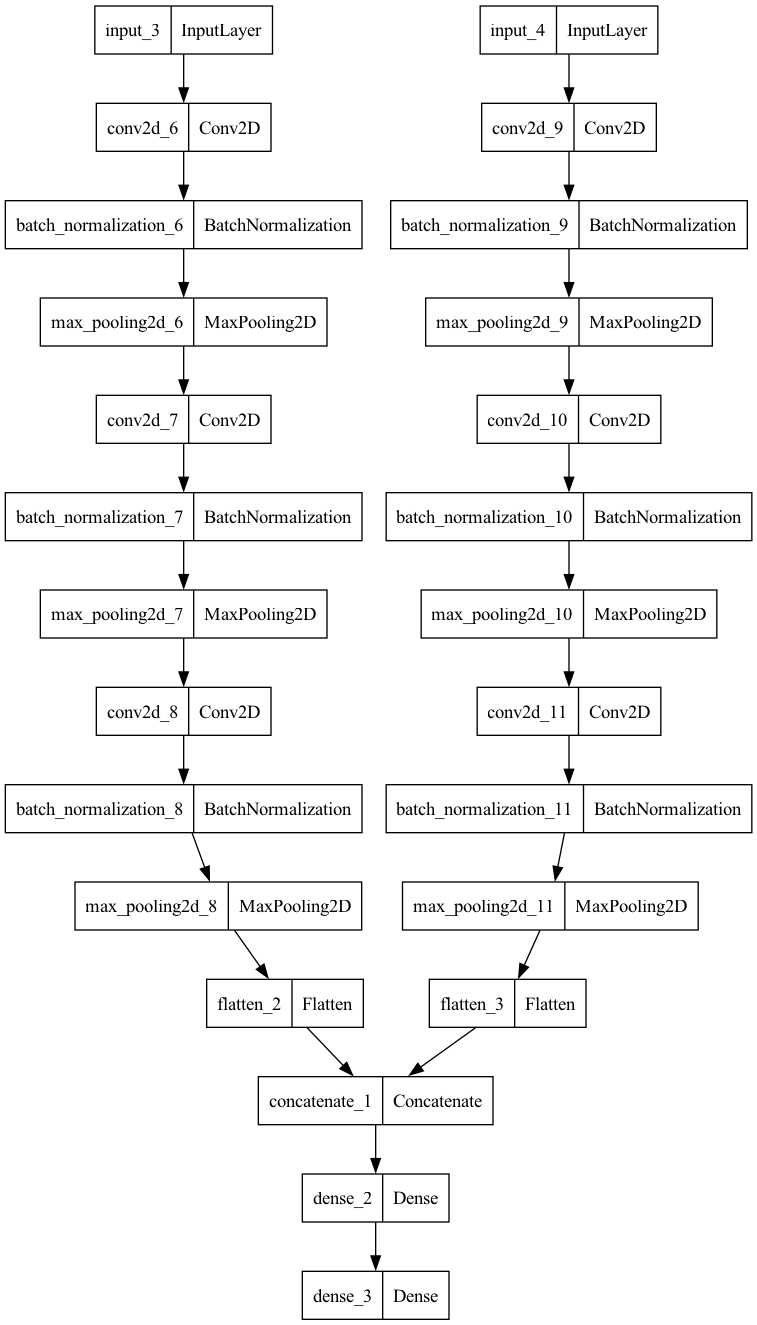

In [33]:
image_shape = x_train_augmented[0].shape
# The input shape to the CNN is the height, width and number of color channels. The spectrograms
# only have one color channel.
input_shape = (image_shape[0], image_shape[1], 1)
print(input_shape)

augmented_input = layers.Input(shape=input_shape)
augmented_model = layers.Conv2D(filters=64, kernel_size=(7, 7), activation='relu')(augmented_input)
augmented_model = layers.BatchNormalization()(augmented_model)
augmented_model = layers.MaxPooling2D((2, 2))(augmented_model)

augmented_model = layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu')(augmented_model)
augmented_model = layers.BatchNormalization()(augmented_model)
augmented_model = layers.MaxPooling2D((2, 2))(augmented_model)

augmented_model = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(augmented_model)
augmented_model = layers.BatchNormalization()(augmented_model)
augmented_model = layers.MaxPooling2D((2, 2))(augmented_model)

# Flatten the 3D image output to 1 dimension
augmented_model = layers.Flatten()(augmented_model)
painted_input = layers.Input(shape=input_shape)
painted_model = layers.Conv2D(filters=64, kernel_size=(7, 7), activation='relu', input_shape=input_shape)(painted_input)
painted_model = layers.BatchNormalization()(painted_model)
painted_model = layers.MaxPooling2D((2, 2))(painted_model)

painted_model = layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu')(painted_model)
painted_model = layers.BatchNormalization()(painted_model)
painted_model = layers.MaxPooling2D((2, 2))(painted_model)

painted_model = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(painted_model)
painted_model = layers.BatchNormalization()(painted_model)
painted_model = layers.MaxPooling2D((2, 2))(painted_model)

# Flatten the 3D image output to 1 dimension
painted_model = layers.Flatten()(painted_model)

output = layers.Concatenate()([augmented_model, painted_model])
output = layers.Dense(64, activation='relu')(output)

label_count = len(spectrograms)
output = layers.Dense(label_count)(output)

tf_model = models.Model(inputs=[augmented_input, painted_input], outputs=[output])

tf_model.summary()
tf.keras.utils.plot_model(tf_model, to_file="output/model.png")

Epoch 1/150
7/7 [==============================] - 1s 81ms/step - loss: 2.7904 - accuracy: 0.3024 - val_loss: 34.0430 - val_accuracy: 0.2584
Epoch 2/150
7/7 [==============================] - 0s 31ms/step - loss: 1.5296 - accuracy: 0.5610 - val_loss: 38.3399 - val_accuracy: 0.2472
Epoch 3/150
7/7 [==============================] - 0s 32ms/step - loss: 1.2278 - accuracy: 0.5707 - val_loss: 34.7052 - val_accuracy: 0.1798
Epoch 4/150
7/7 [==============================] - 0s 33ms/step - loss: 0.8126 - accuracy: 0.7024 - val_loss: 28.2521 - val_accuracy: 0.2135
Epoch 5/150
7/7 [==============================] - 0s 37ms/step - loss: 0.7692 - accuracy: 0.6927 - val_loss: 22.9967 - val_accuracy: 0.1910
Epoch 6/150
7/7 [==============================] - 0s 31ms/step - loss: 0.5829 - accuracy: 0.6878 - val_loss: 20.0710 - val_accuracy: 0.1573
Epoch 7/150
7/7 [==============================] - 0s 32ms/step - loss: 0.5916 - accuracy: 0.7610 - val_loss: 13.1041 - val_accuracy: 0.2472
Epoch 8/150
7

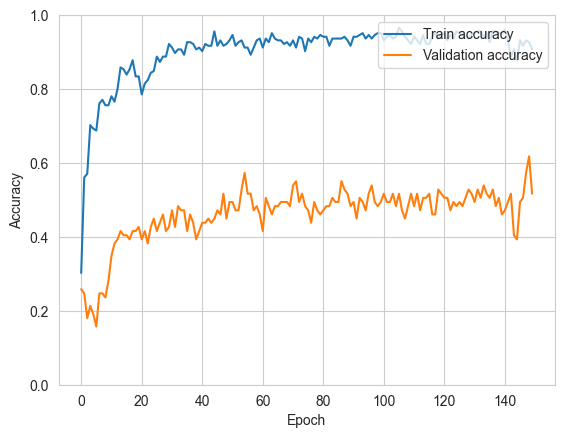

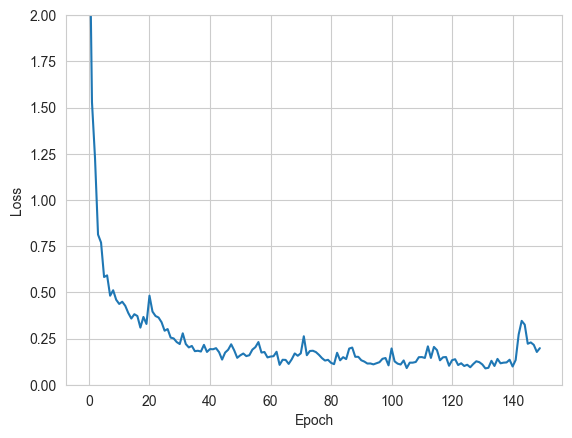

In [34]:
tf_model.compile(optimizer='adam',
                 loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

# convert ints to the type of int that can be used in a Tensor
history = tf_model.fit(x=[x_train_augmented, x_train_painted],
                       y=y_train,
                       epochs=150,
                       validation_data=([x_test_augmented, x_test_painted], y_test))

plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.show()

plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.show()

In [10]:
final_loss, final_acc = tf_model.evaluate([x_test_augmented, x_test_painted], y_test, verbose=1)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

3/3 [==============================] - 0s 15ms/step - loss: 1.9547 - accuracy: 0.5506
Final loss: 1.954743, final accuracy: 0.550562


In [11]:
output_file = "output/spectrum-painting-model.keras"

tf.saved_model.save(tf_model, "output/")
tf_model.save(output_file)

INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


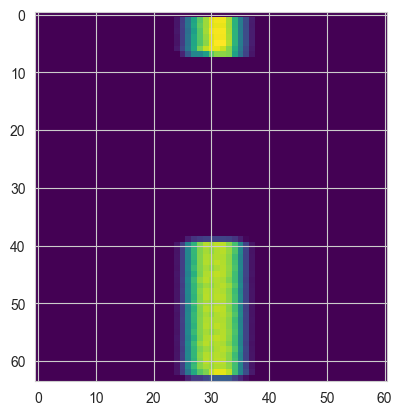

1/1 [==============================] - 0s 26ms/step
z


In [53]:
def predict_full_model(model: models.Model,
                       x_augmented: npt.NDArray[np.uint8],
                       x_painted: npt.NDArray[np.uint8]) -> str:
    x_augmented.shape += (1,)
    x_augmented = (np.expand_dims(x_augmented, 0))

    x_painted.shape += (1,)
    x_painted = (np.expand_dims(x_painted, 0))

    predictions_single = model.predict(x=[(x_augmented, x_painted)])
    prediction_index = np.argmax(predictions_single[0])
    return label_names[prediction_index]


# Predict with full Tensorflow
test_img_augmented = x_test_augmented[0]
test_img_painted = x_test_painted[0]

plt.imshow(test_img_augmented, cmap='viridis')
plt.show()

prediction = predict_full_model(tf_model, test_img_augmented, test_img_painted)

print(prediction)

1/1 [==============================] - 0s 10ms/step


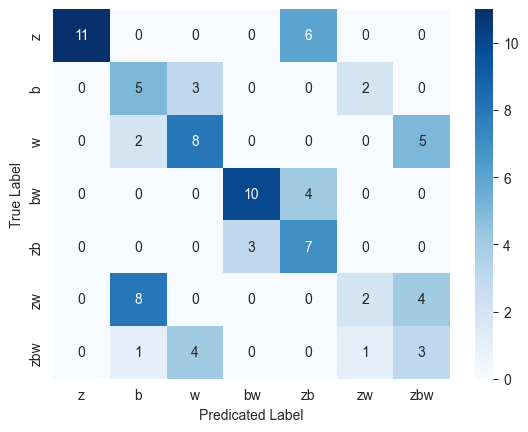

In [54]:
def plot_confusion_matrix(y_predictions: npt.NDArray[np.uint8],
                          y_test: npt.NDArray[np.uint8]):
    cm = confusion_matrix(np.array(label_names)[y_test], y_predictions)

    plt.figure()
    plot = seaborn.heatmap(cm, xticklabels=label_names, yticklabels=label_names, annot=True, cmap='Blues')
    plot.get_figure()
    plt.ylabel('True Label')
    plt.xlabel('Predicated Label')
    plt.show()


tf_model_y_predictions = [predict_full_model(tf_model, x_a, x_p) for (x_a, x_p) in
                          zip(x_test_augmented, x_test_painted)]
plot_confusion_matrix(tf_model_y_predictions, y_test)

In [31]:
def representative_data_gen():
    # Convert test images to float32 and the correct dimensions
    # for TensorFlow to do full-integer quantization.
    repr_augmented_images = np.copy(x_test_augmented)
    repr_augmented_images = [img.astype(np.float32) for img in repr_augmented_images]

    for img in repr_augmented_images:
        img.shape += (1,)

    repr_painted_images = np.copy(x_test_painted)
    repr_painted_images = [img.astype(np.float32) for img in repr_painted_images]

    for img in repr_painted_images:
        img.shape += (1,)

    augmented_images = tf.data.Dataset.from_tensor_slices(repr_augmented_images).batch(1).take(100)
    painted_images = tf.data.Dataset.from_tensor_slices(repr_painted_images).batch(1).take(100)
    for aug_value, painted_value in list(zip(augmented_images, painted_images)):
        # Model has only one input so each data point has one element.

        yield [aug_value, painted_value]


# This requires TensorFlow <= 2.15.0 for it to work. See https://github.com/tensorflow/tensorflow/issues/63987
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

print("Converting...")
tflite_model = converter.convert()
print(f"Done. Model size = {len(tflite_model) // 1000} KB")

# Save the model.
with open('output/spectrum-painting-model.tflite', 'wb') as f:
    f.write(tflite_model)


Converting...
INFO:tensorflow:Assets written to: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmp5lmvauxk/assets


INFO:tensorflow:Assets written to: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmp5lmvauxk/assets
/Users/sethd/Desktop/spectrum-painting/venv/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-05-20 18:40:11.289253: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-20 18:40:11.289265: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-20 18:40:11.289425: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmp5lmvauxk
2024-05-20 18:40:11.291514: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-20 18:40:11.291521: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/81/3wz7wxg90f3

Done. Model size = 229 KB


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


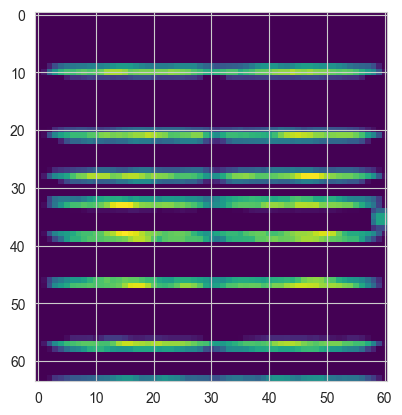

Prediction: w


In [50]:
# Test with Tensorflow Lite
def predict_lite_model(model: List[bytes],
                       x_augmented: npt.NDArray[np.uint8],
                       x_painted: npt.NDArray[np.uint8]) -> str:
    x_augmented.shape += (1,)
    x_augmented = (np.expand_dims(x_augmented, 0))

    x_painted.shape += (1,)
    x_painted = (np.expand_dims(x_painted, 0))

    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    interpreter.set_tensor(0, x_augmented)
    interpreter.set_tensor(1, x_painted)

    interpreter.invoke()

    prediction = interpreter.get_tensor(output_details["index"])[0]
    prediction_index = np.argmax(prediction)
    return label_names[prediction_index]


test_img_augmented = x_test_augmented[2]
test_img_painted = x_test_painted[2]

plt.imshow(test_img_augmented, cmap="viridis")
plt.show()

prediction = predict_lite_model(tflite_model, test_img_augmented, test_img_painted)
print(f"Prediction: {prediction}")

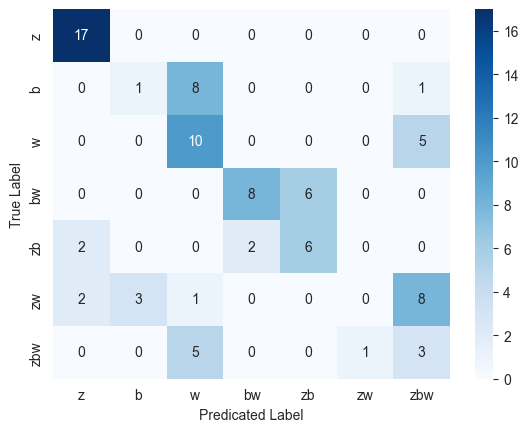

In [55]:
tflite_model_y_predictions = [predict_lite_model(tflite_model, x_a, x_p) for (x_a, x_p) in
                              zip(x_test_augmented, x_test_painted)]

plot_confusion_matrix(tflite_model_y_predictions, y_test)

In [ ]:
test_img_augmented = x_test_augmented[2]
test_img_painted = x_test_painted[2]

plt.imshow(test_img_augmented)
plt.show()

test_img_augmented.shape += (1,)
test_img_augmented = (np.expand_dims(test_img_augmented, 0))
test_img_augmented = test_img_augmented.astype(np.float32)

test_img_painted.shape += (1,)
test_img_painted = (np.expand_dims(test_img_painted, 0))
test_img_painted = test_img_painted.astype(np.float32)

with open('output/augmented_image.bytes', 'wb') as f:
    f.write(test_img_augmented.tobytes())

with open('output/painted_image.bytes', 'wb') as f:
    f.write(test_img_painted.tobytes())

# with serial.Serial("/dev/cu.usbmodem2101", timeout=5) as ser:
#     ser.write(augmented_bytes)
#     ser.write(painted_bytes)
#     print(ser.readline())
#     print(ser.readline())
#     print(ser.readline())
#     print(ser.readline())
#     print(ser.readline())
